# Implicit Regularization

In this demo, we'll investigate how neural networks can automatically select *simple* functions in the regime when the number of parameters exceeds the number of samples.

In traditional machine learning classes, we learn that there is a trade off between bias (how well a model fits the training data) and variance (how well the model fits the test data). The story normally looks like the following:

<img src="http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png" width=500 />

[Image Source](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html)

However, deep learning models often have many more parameters than samples and *even* perform better when more parameters are added.

In this demo, we'll take a look at a particular example of a two-layer network fitting a simple data set.

In [1]:
# Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

The task we consider is predicting an abalone's age from eight different features.

<img src="https://static01.nyt.com/images/2014/06/06/dining/Monterey-Bay-Abalone/Monterey-Bay-Abalone-articleLarge.jpg" width=200/>

[Image Source](https://cooking.nytimes.com/recipes/1012700-monterey-bay-abalone-meuniere-style)

The reason we chose this task is because there are under 5000 training examples and we can learn it fairly quickly (about 5 seconds for 10 epochs of training our network).

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

--2023-01-31 19:13:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: ‘abalone.data’

abalone.data        100%[===================>] 187.38K  --.-KB/s    in 0.1s    

2023-01-31 19:13:26 (1.56 MB/s) - ‘abalone.data’ saved [191873/191873]



We'll define a custom dataset class for loading the data.

In [3]:
class AbaloneData(Dataset):
  def __init__(self, data):
    self.data = data
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    row = list(self.data.iloc[idx])
    # We turn the first variable from categorical sex to binary
    x = [0 if row[0]=='M' else 1] + row[1:8]
    y = row[8]
    x = torch.tensor(x).double().to(self.device)
    y = torch.tensor(y).double().to(self.device)
    return x, y

We'll load the data, shuffle the rows, and then split into training and testing. For simplicity, we'll only consider 4000 examples and split 3/4-1/4 training-testing.

In [4]:
csv = pd.read_csv('abalone.data', header=None).sample(frac=1) 
# sample shuffles rows
train_loader = DataLoader(AbaloneData(csv[:3000]), batch_size=1000, shuffle=True)
test_loader = DataLoader(AbaloneData(csv[3000:4000]), batch_size=1000)

Our model will be a simple two-layer network where we explicitly pass in the number of nodes in each linear layer. This allows us to control the 'complexity' of the model.

In [5]:
class Model(nn.Module):
  def __init__(self, layer_size):
    super(Model, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(8, layer_size, bias=False),
        nn.ReLU(),
        nn.Linear(layer_size, 1, bias=False),
        nn.ReLU()
    )
  
  def forward(self, x):
    return self.layers(x)

In this function, we'll load the model of appropriate size, train it for some number of epochs, and get the loss **on the test set**. Of course, we know that a model will always improve on the training set as we increase its complexity but traditional machine learning tells us we will see a corresponding loss on the test set.

In [6]:
def get_test_loss(layer_size, epochs):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Model(layer_size).to(device).double()
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=.01)

  for epoch in range(epochs):
    train_loss = 0
    for x,y in train_loader:
      optimizer.zero_grad()
      yhat = model(x).squeeze()
      loss = criterion(yhat, y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    
  test_loss = 0
  x,y = next(iter(test_loader)) 
  with torch.no_grad():
    yhat = model(x).squeeze()
    loss = criterion(yhat, y)
    test_loss += loss.item() 
  
  num_param = sum([p.numel() for p in model.parameters()])

  return test_loss, num_param

Let's compare the test loss and number of parameters (as a proxy for model complexity).

In [7]:
test_losses = []
num_params = []
epochs = 10
num_runs = 10
for layer_size in range(1, 250, 20):
  avg_test_loss = 0
  for run in range(num_runs):
    test_loss, num_param = get_test_loss(layer_size, epochs)
    while test_loss > 15: # strange bug where the model doesn't learn
      test_loss, num_param = get_test_loss(layer_size, epochs)    
    avg_test_loss += test_loss / num_runs
  print(f'Layer Size: {layer_size} \t Num Param: {num_param} \t Test Loss: {avg_test_loss}')
  test_losses += [avg_test_loss]
  num_params += [num_param]

Layer Size: 1 	 Num Param: 9 	 Test Loss: 11.722644500583451
Layer Size: 21 	 Num Param: 189 	 Test Loss: 11.550089262171284
Layer Size: 41 	 Num Param: 369 	 Test Loss: 11.512538071489129
Layer Size: 61 	 Num Param: 549 	 Test Loss: 11.533856738537652
Layer Size: 81 	 Num Param: 729 	 Test Loss: 11.409612632669647
Layer Size: 101 	 Num Param: 909 	 Test Loss: 11.47033837825856
Layer Size: 121 	 Num Param: 1089 	 Test Loss: 11.325164832796315
Layer Size: 141 	 Num Param: 1269 	 Test Loss: 11.252145172836409
Layer Size: 161 	 Num Param: 1449 	 Test Loss: 11.083251408175496
Layer Size: 181 	 Num Param: 1629 	 Test Loss: 11.003746206810977
Layer Size: 201 	 Num Param: 1809 	 Test Loss: 11.14775270552098
Layer Size: 221 	 Num Param: 1989 	 Test Loss: 10.9684626027181
Layer Size: 241 	 Num Param: 2169 	 Test Loss: 10.872713101526905


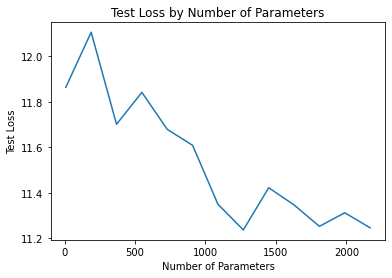

In [ ]:
plt.title('Test Loss by Number of Parameters')
plt.plot(num_params, test_losses)
plt.xlabel('Number of Parameters')
plt.ylabel('Test Loss')
plt.show()